# Analysis

In [1]:
cd ..

/Users/casperneo/work/cloud-research/clouds


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Imports are relative to `clouds/`
from reproduction.pipeline import load as pipeline
from reproduction.analysis import img_scatter

import os
import tensorflow as tf
from tensorflow.contrib.data import shuffle_and_repeat, batch_and_drop_remainder

from matplotlib import pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
from sklearn.manifold import TSNE

/anaconda3/envs/clouds/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/envs/clouds/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/envs/clouds/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/envs/clouds/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/envs/clouds/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## 1. Load Data

In [6]:
img_width = 64
batch_size = 32
use_hdf_data = True

In [7]:
def has_data(null_value, threshold):
    def fn(x):
        nulls = tf.equal(x, null_value)
        null_freq = tf.reduce_mean(tf.cast(nulls, tf.float32))
        return null_freq < threshold
    return fn

### TIF Data

In [8]:
tiff_files = ["data/tif/2017-01-01_MOD09GA_background_removal_zero_inputated_image_with_cf_50perc_grid_size10-0000017664-0000000000.tif"]
n_bands = 7
tif_fields = ["b%d"%(i+1) for i in range(n_bands)]
tif_dataset = (
    tf.data.Dataset.from_generator(
        pipeline.read_tiff_gen(tiff_files, img_width),
        tf.int16,
        (img_width, img_width, n_bands)
    )
    .filter(has_data(0, 0.3))
    .apply(tf.contrib.data.shuffle_and_repeat(100))
    .apply(batch_and_drop_remainder(batch_size))
)

### HDF data

In [63]:
meta_json = "experimental/test/ex.json"
hdf_fields = ["Cloud_Optical_Thickness","Cloud_Water_Path","Cloud_Effective_Radius"]
data_files = [
    "data/nasa/MOD06_L2.A2017001.1005.061.2017312165249.tfrecord",
    "data/nasa/MOD06_L2.A2017001.1045.061.2017312172343.tfrecord",
    "data/nasa/MOD06_L2.A2017001.1050.061.2017312171554.tfrecord"
]

def heterogenous_bands(threshold):
    """Returns True if a band in the image has too much of a single value in
    `threshold` fraction of the image. Presumably this value represents no cloud
    as clouds will be more heterogenous.
    """

    def fn(img):
        has_data = []
        for band in tf.unstack(img, axis=-1):
            _, _, count = tf.unique_with_counts(tf.reshape(band, [-1]))
            has_data.append(tf.reduce_max(count) / tf.size(band) < threshold)
        return tf.reduce_any(has_data)

    return fn

def normalizer(x):
    corrected = tf.clip_by_value(x, 0, 1e10)
#     return corrected / (0.01 + tf.reduce_max(corrected, axis=(0, 1, 2)))
    return corrected

chans, parser = pipeline.main_parser(hdf_fields, meta_json)
hdf_dataset = (
    tf.data.Dataset.from_tensor_slices(data_files)
    .apply(shuffle_and_repeat(100))
    .flat_map(tf.data.TFRecordDataset)
    .map(parser)
    .map(normalizer)
    .interleave(pipeline.patchify_fn(img_width, img_width, chans), cycle_length=4)
    .filter(heterogenous_bands(0.5))
    .shuffle(10)
    .apply(batch_and_drop_remainder(batch_size))
)

### Load

In [64]:
if use_hdf_data:
    dataset = hdf_dataset
    fields = hdf_fields
else:
    dataset = tif_dataset
    fields = tif_fields

x = dataset.make_one_shot_iterator().get_next()
with tf.Session() as sess:
    y = sess.run(x)

### Plot

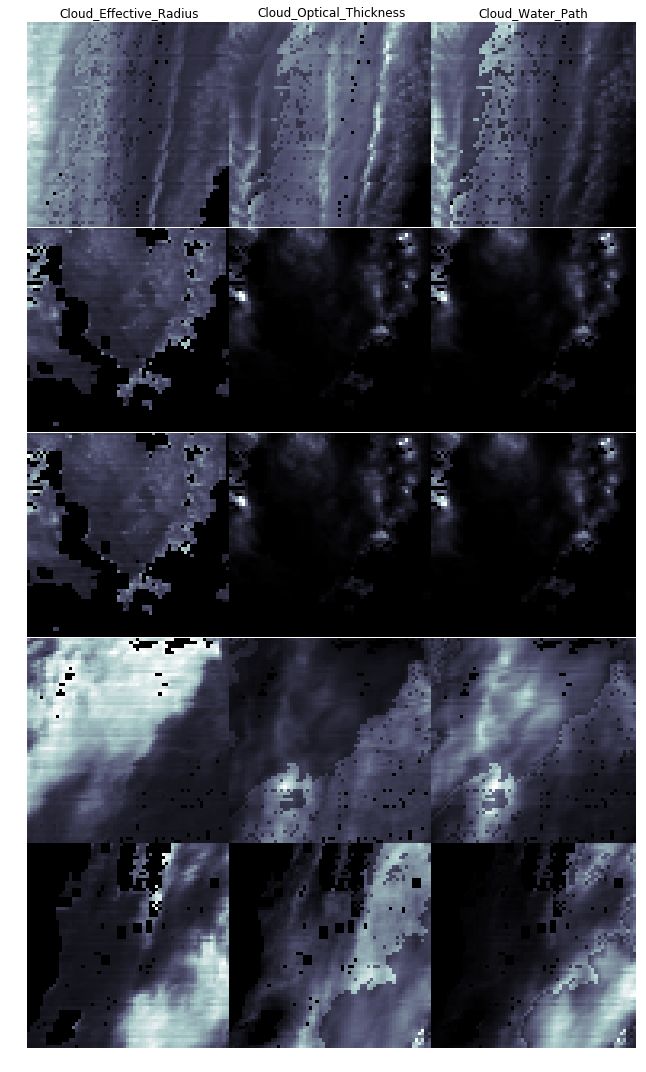

In [65]:
samples = 5
width = 3
fig, ax = plt.subplots(
    nrows=samples,
    ncols=len(fields),
    figsize=(len(fields) * width, samples * width),
)
# plt.subplots_adjust(wspace=0.01, hspace=0.01)
for r in range(samples):
    for c, field in enumerate(fields):
        a = ax[r, c]
        a.imshow(y[r,:,:,c], cmap="bone")
        a.set_axis_off()
        if r == 0:
            a.set_title(field)

fig.tight_layout(w_pad=-2, h_pad=-2)

### Plot histogram of channel distribution

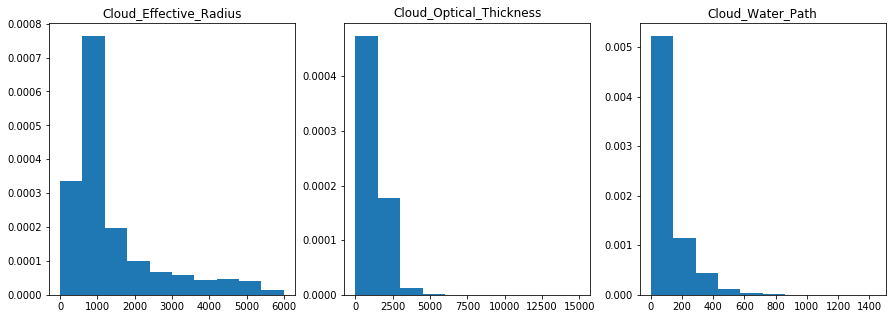

In [66]:
fig, ax = plt.subplots(ncols=len(fields), figsize=(len(fields) * 5, 5))

for i, f in enumerate(fields):
    a = ax[i]
    a.hist(y[:,:,:,i].flatten(), density=True)
    a.set_title(f)

## Load Model

In [67]:
model_dir = "experimental/m19/"
# !head -n 20 output/m9/run-m9.sbatch_4294967294.out

In [68]:
with open(model_dir + "ae.json", "r") as f:
    ae = tf.keras.models.model_from_json(f.read())
ae.load_weights(model_dir + "ae.h5")
ae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ae_input (InputLayer)        (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 8)         224       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 8)         584       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 16)        1168      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 16)        2320      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 32)        4640      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 32)          9248      
__________

### Autoencoder output
Each column is a field (labeled), each row triplet of rows is a sample. The triplets are original, difference, and autoencoded

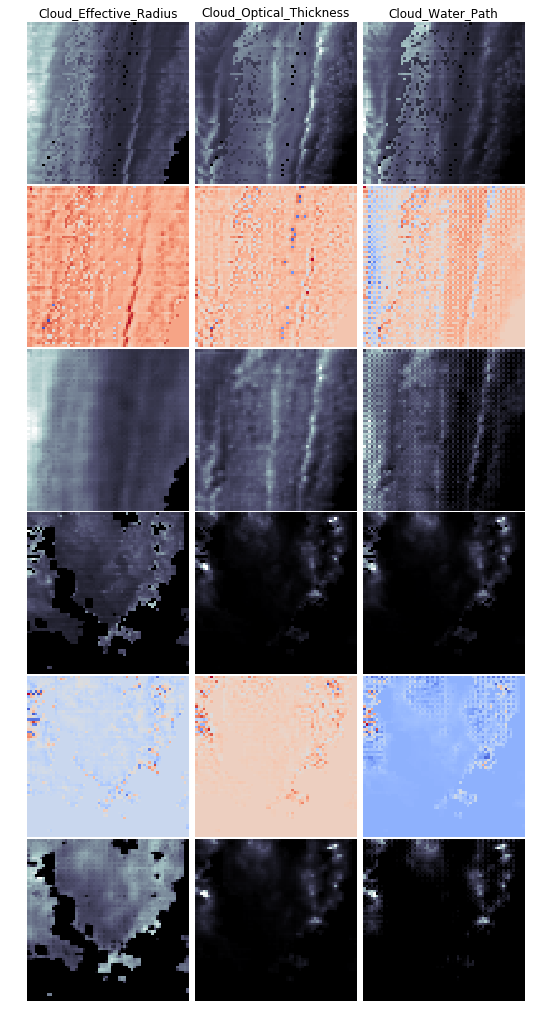

In [69]:
enc, dec = ae.predict(y.astype(np.float32))

samples = 2
width = 3
fig, ax = plt.subplots(
    nrows=samples * 3,
    ncols=len(fields),
    figsize=(len(fields) * width, samples * width * 3)
)
plt.subplots_adjust(wspace=0.01, hspace=0.01)

for s in range(samples):
    for c, field in enumerate(fields):
        orig = ax[s * 3, c]
        orig.imshow(y[s,:,:, c], cmap="bone")
        if s == 0: orig.set_title(field)
        
        diff = ax[s * 3 + 1, c]
        diff.imshow(y[s,:,:, c] - dec[s, :, :, c], cmap="coolwarm")
            
        out = ax[s * 3 + 2, c]
        out.imshow(dec[s, :, :, c], cmap="bone")
for a in ax.flatten():
    a.set_axis_off()

## Analysis

### Get more data 

In [194]:
n = 3200

imgs = []
with tf.Session() as sess:
    for _ in range(n // batch_size):
        imgs.append(sess.run(x))
        
encodings = []
for y in imgs:
    enc, _ = ae.predict(y.astype(np.float32))
    encodings.extend(list(enc.mean(axis=(1,2))))

tmp = []
for i in imgs:
    tmp.extend(list(i))
imgs = np.array(tmp)
encodings = np.array(encodings)

### Compute PCA

In [195]:
centered = encodings - encodings.mean(axis=0)
cov = centered.transpose().dot(centered) / centered.shape[0]
evals, evecs = np.linalg.eigh(cov)
evals = np.flip(evals)
evecs = np.flip(evecs, axis=1)

#### Principle Components and $R^2$

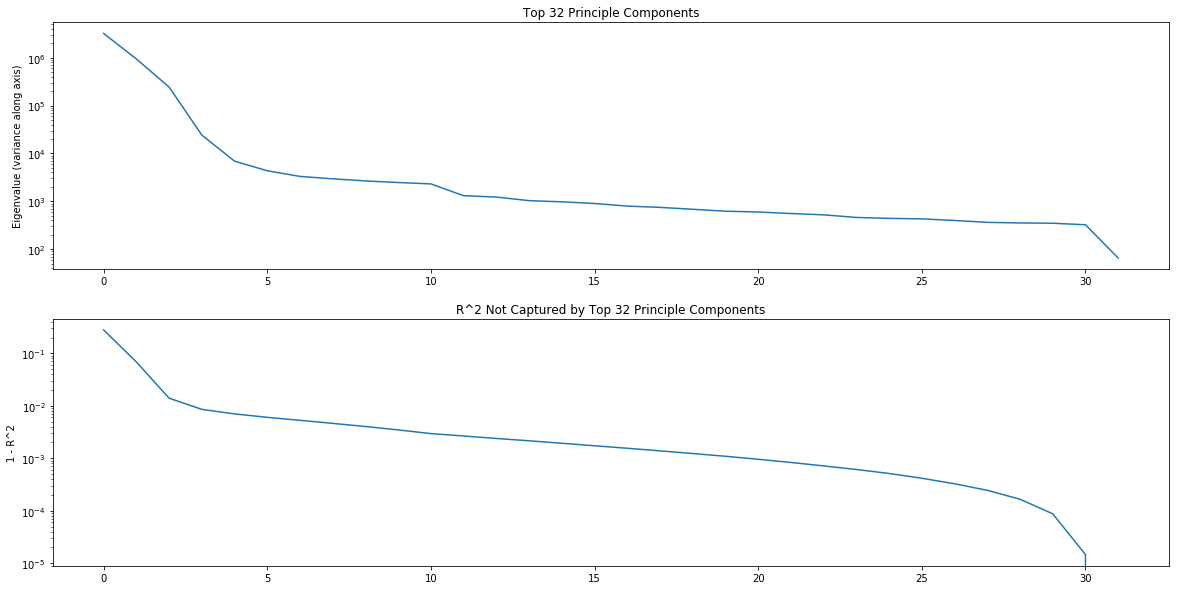

In [200]:
D = evals.shape[0]
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(20, 10))

ax1.plot(evals[:D])
ax1.set_title("Top %d Principle Components"% D)
ax1.set_yscale("log")
ax1.set_ylabel("Eigenvalue (variance along axis)")

ax2.plot(1 - evals.cumsum()[:D] / evals.sum())
ax2.set_title("R^2 Not Captured by Top %d Principle Components"%D)
ax2.set_yscale("log")
ax2.set_ylabel("1 - R^2");

### PCA Projection

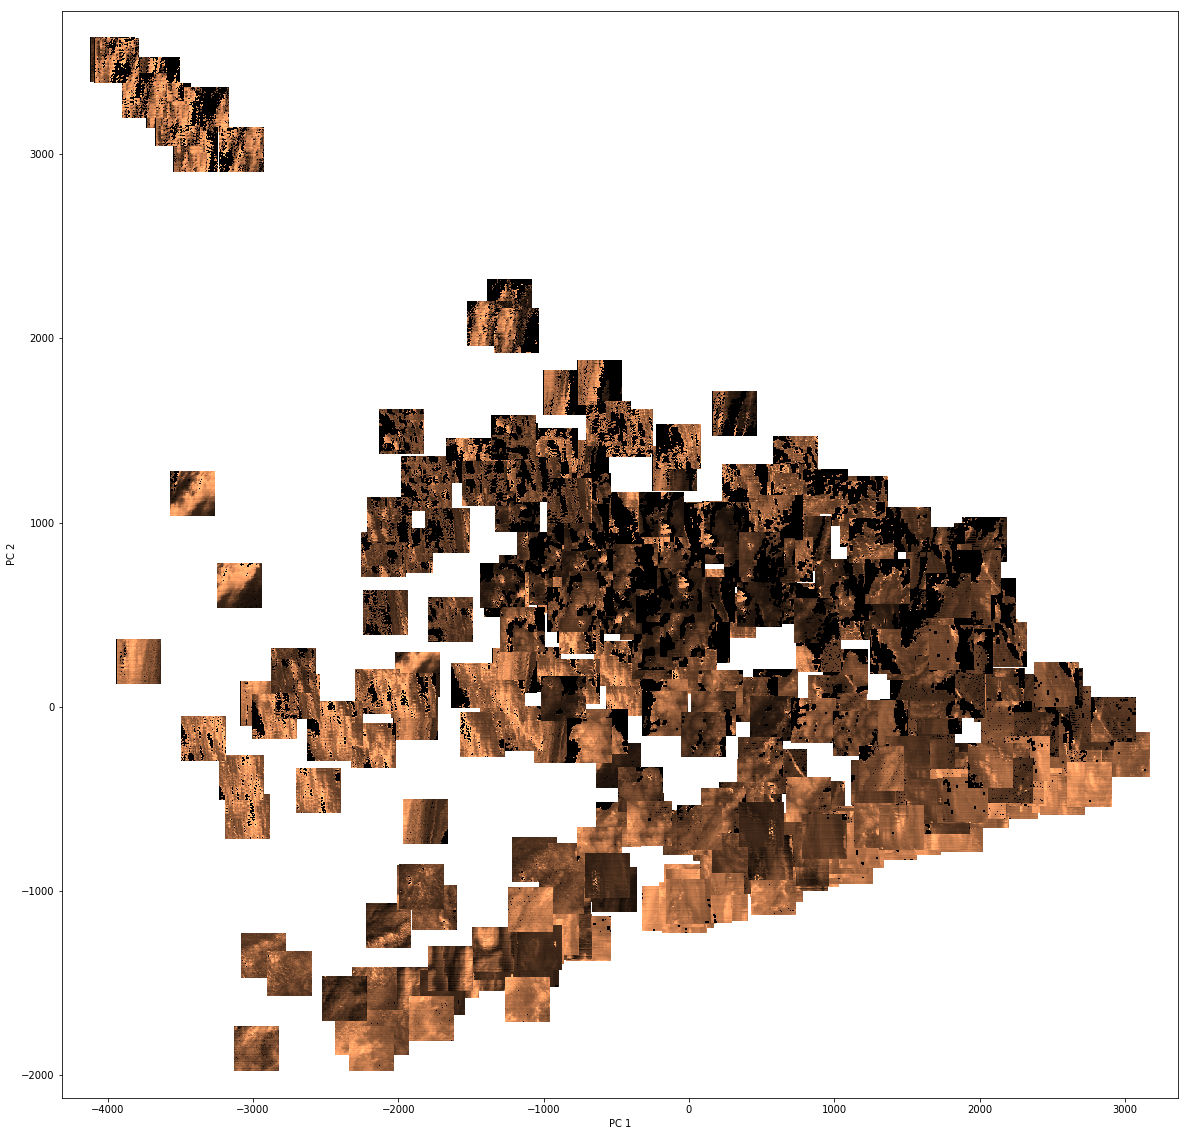

In [201]:
N = 500
# This is zero indexed
dimensions = [0, 1]

projected = centered.dot(evecs[:, dimensions])
fig, ax = img_scatter(
    projected[:N], 
    [y[:,:,0] for y in imgs[:N]],
    zoom=0.7
)
ax.set_xlabel("PC %d"%(dimensions[0] + 1))
ax.set_ylabel("PC %d"%(dimensions[1] + 1));

### T-SNE Projection

In [202]:
N = 500
dims = 50
projected = centered[:N,:].dot(evecs[:, :dims])
embedding = TSNE(n_components=2).fit_transform(projected)

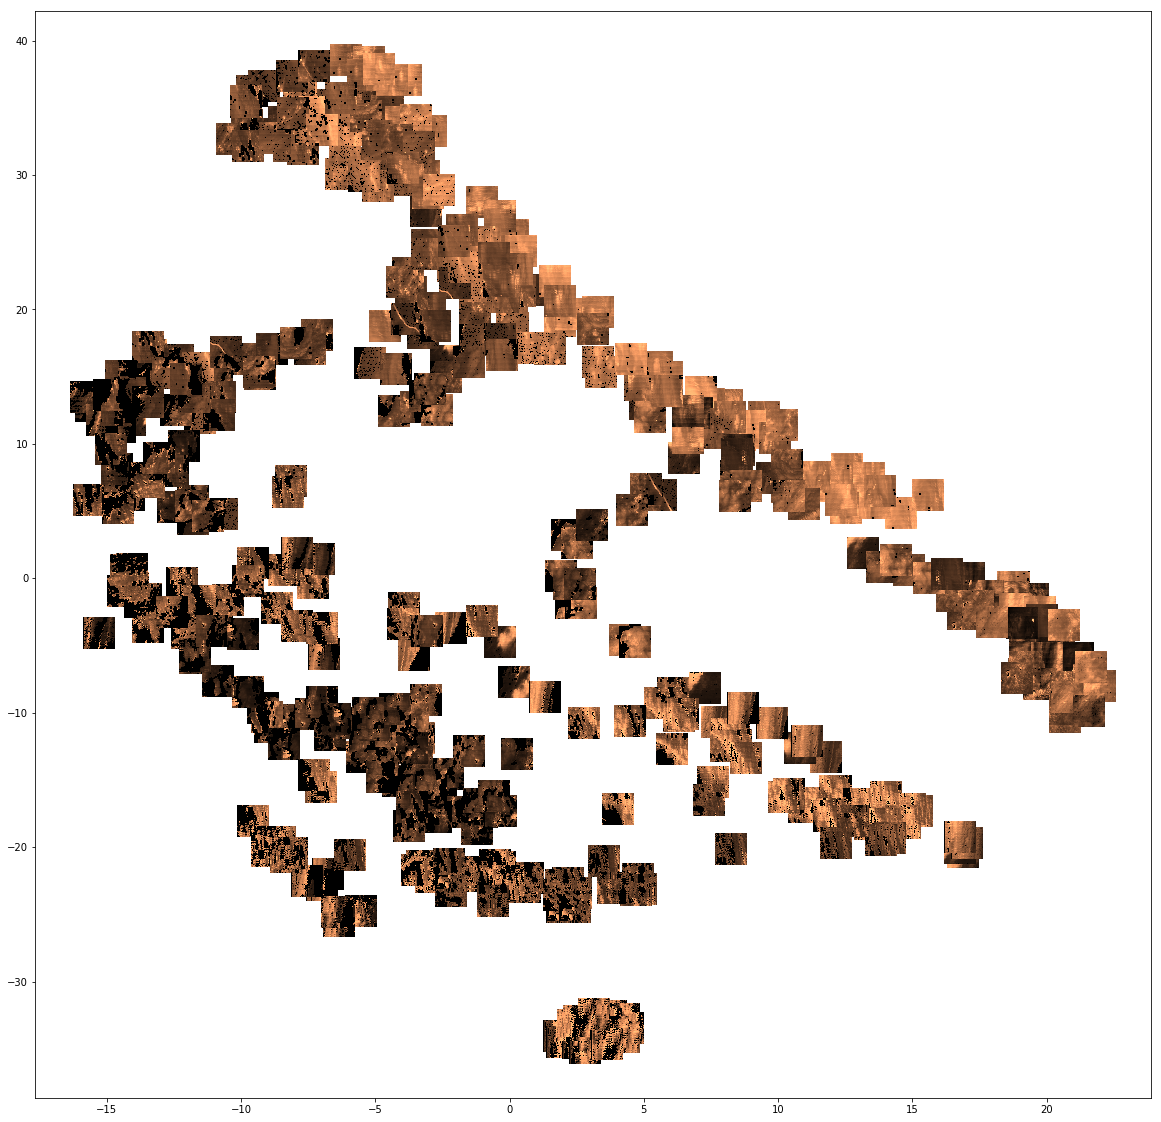

In [203]:
fig, ax = img_scatter(
    embedding,
    [y[:,:,0] for y in imgs[:N]],
)

# Cluster Analysis

In [204]:
from sklearn import cluster
import pandas as pd
from reproduction.analysis import plot_cluster_channel_distributions, plot_cluster_samples

In [205]:
n_clusters = 10
sc = cluster.SpectralClustering(n_clusters, affinity="nearest_neighbors").fit(encodings)
km = cluster.KMeans(n_clusters).fit(encodings)
imgs = np.array(imgs)

In [206]:
def clusterfy(labels):
    n_clusters = len(set(labels))
    clusters = [set() for _ in range(n_clusters)]
    for i, l in enumerate(labels):
        clusters[l].add(i)
    return clusters

def jaccard_similarity(s1, s2):
    return len(s1 & s2) / len(s1 | s2)

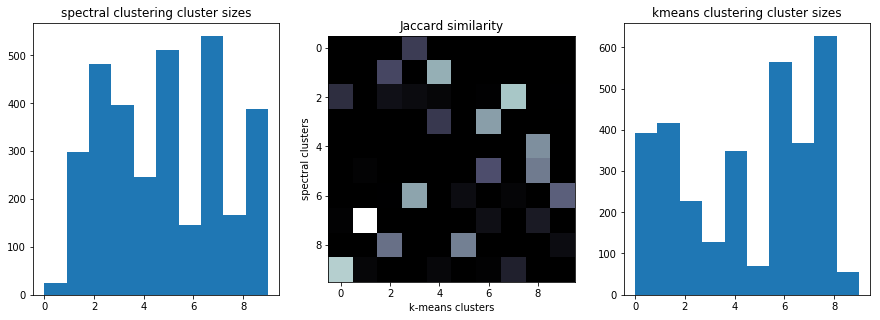

In [207]:
%matplotlib inline
fig, (a, b, c) = plt.subplots(ncols=3, figsize=(15,5))
a.hist(sc.labels_)
a.set_title("spectral clustering cluster sizes")
c.hist(km.labels_);
c.set_title("kmeans clustering cluster sizes")

c1s = clusterfy(sc.labels_)
c2s = clusterfy(km.labels_)
jsims = np.zeros((len(c1s), len(c2s)))
for i, c1 in enumerate(c1s):
    for j, c2 in enumerate(c2s):
        jsims[i, j] =  jaccard_similarity(c1, c2)
        
b.set_ylabel("spectral clusters")
b.set_xlabel("k-means clusters")
b.set_title("Jaccard similarity")
b.imshow(jsims, cmap="bone");

Jaccard similarity is defined $Sim(A,B) = \frac{|A\cap B|}{|A\cup B|}$ so the center matrix corresponds to how similar the clusters are between the two clustering methods. Ideally, the clusters would have a 1 to 1 correspondence and we'd see a single white square for every row and column

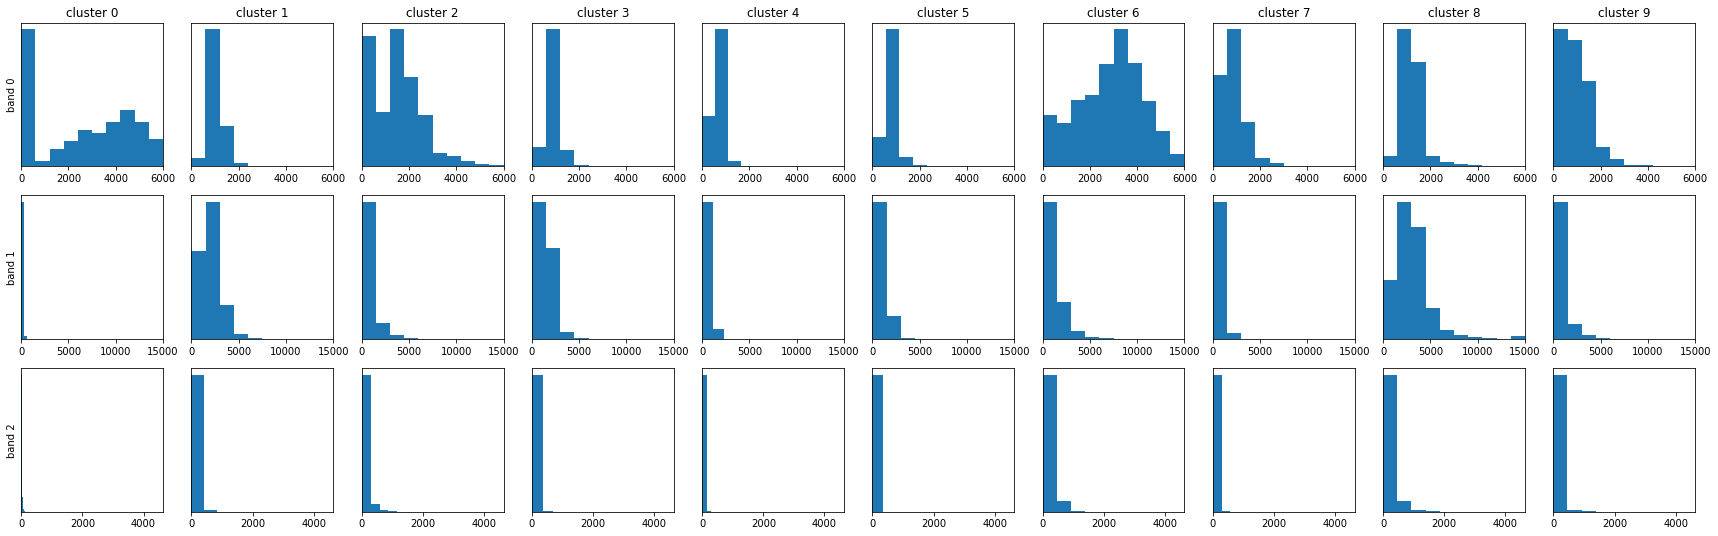

In [208]:
fig, ax = plot_cluster_channel_distributions(imgs, sc.labels_)

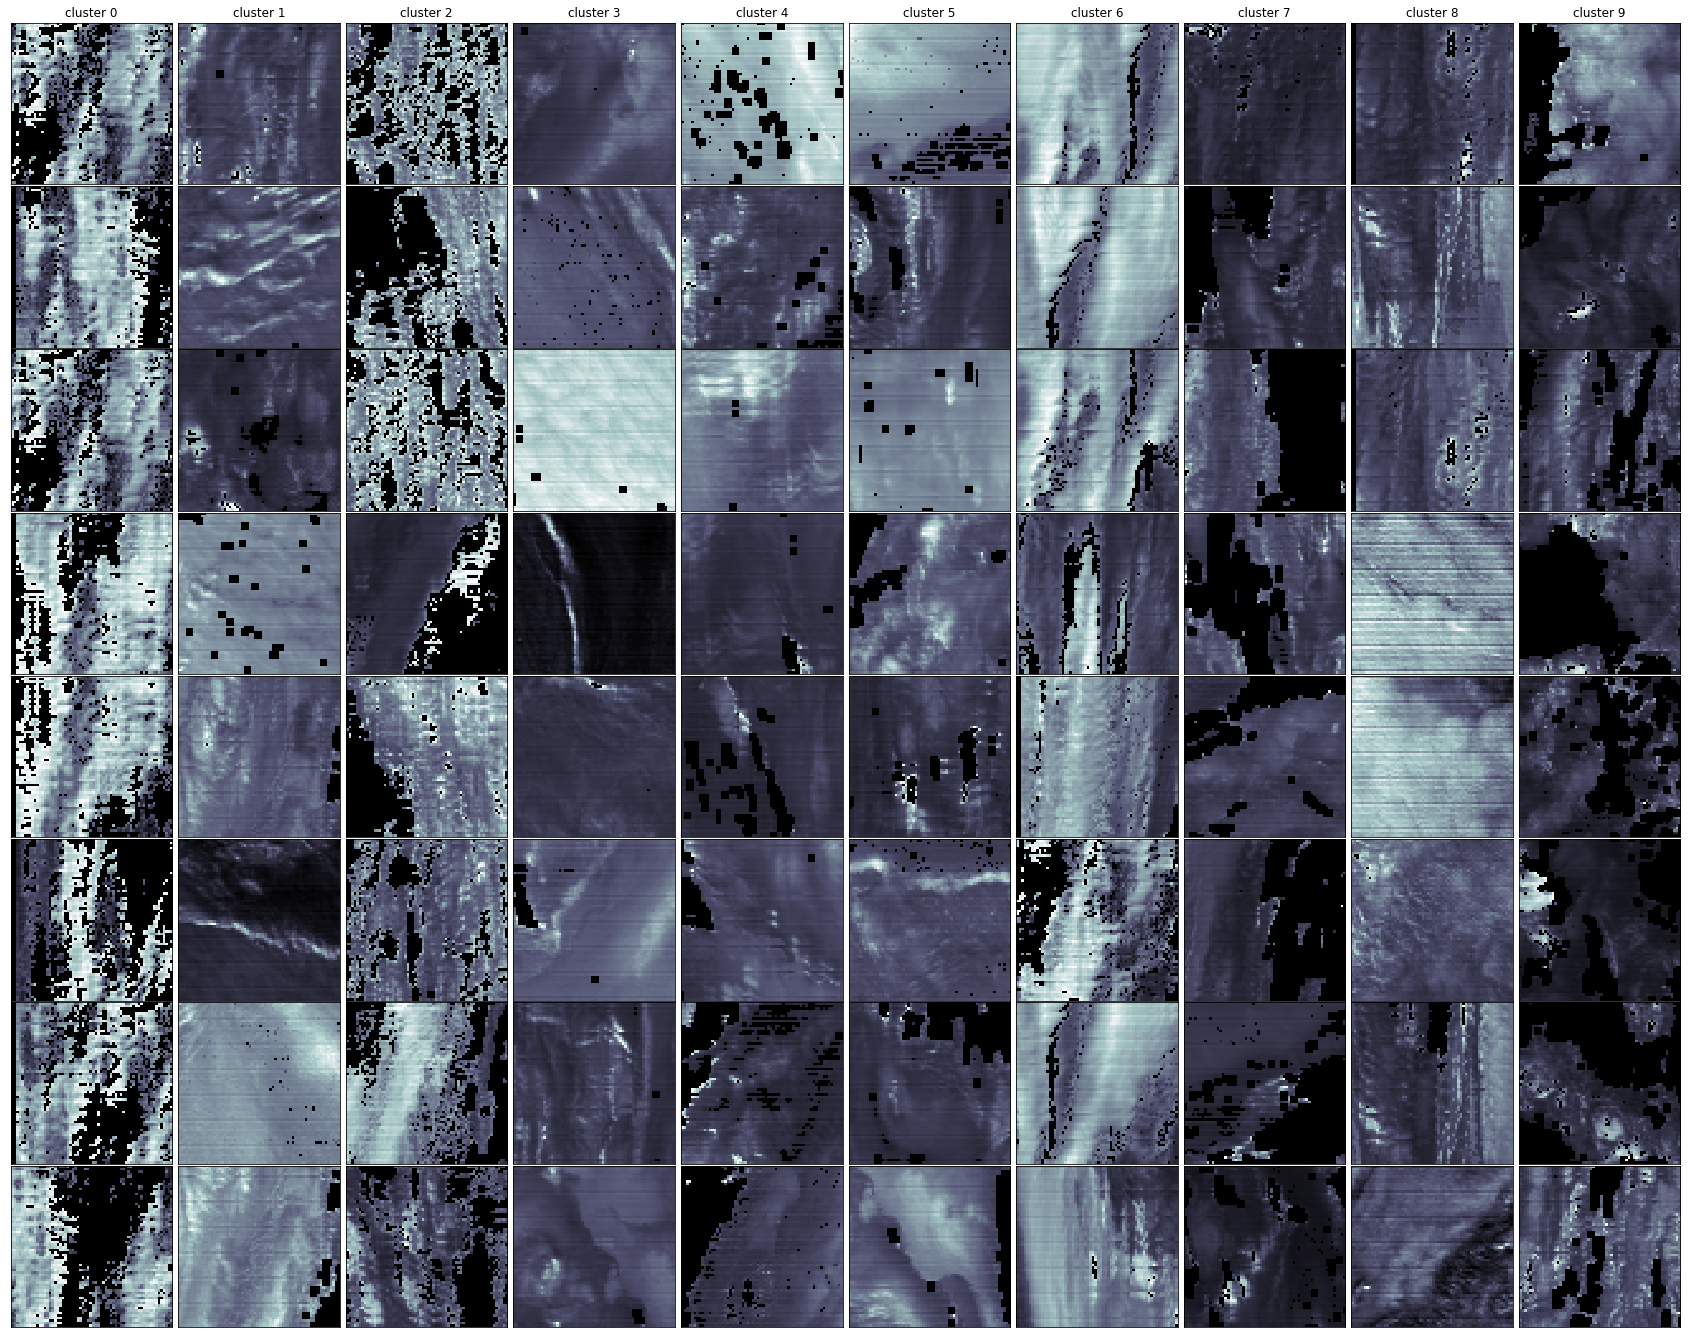

In [210]:
%matplotlib inline
fig, ax = plot_cluster_samples(imgs, sc.labels_)

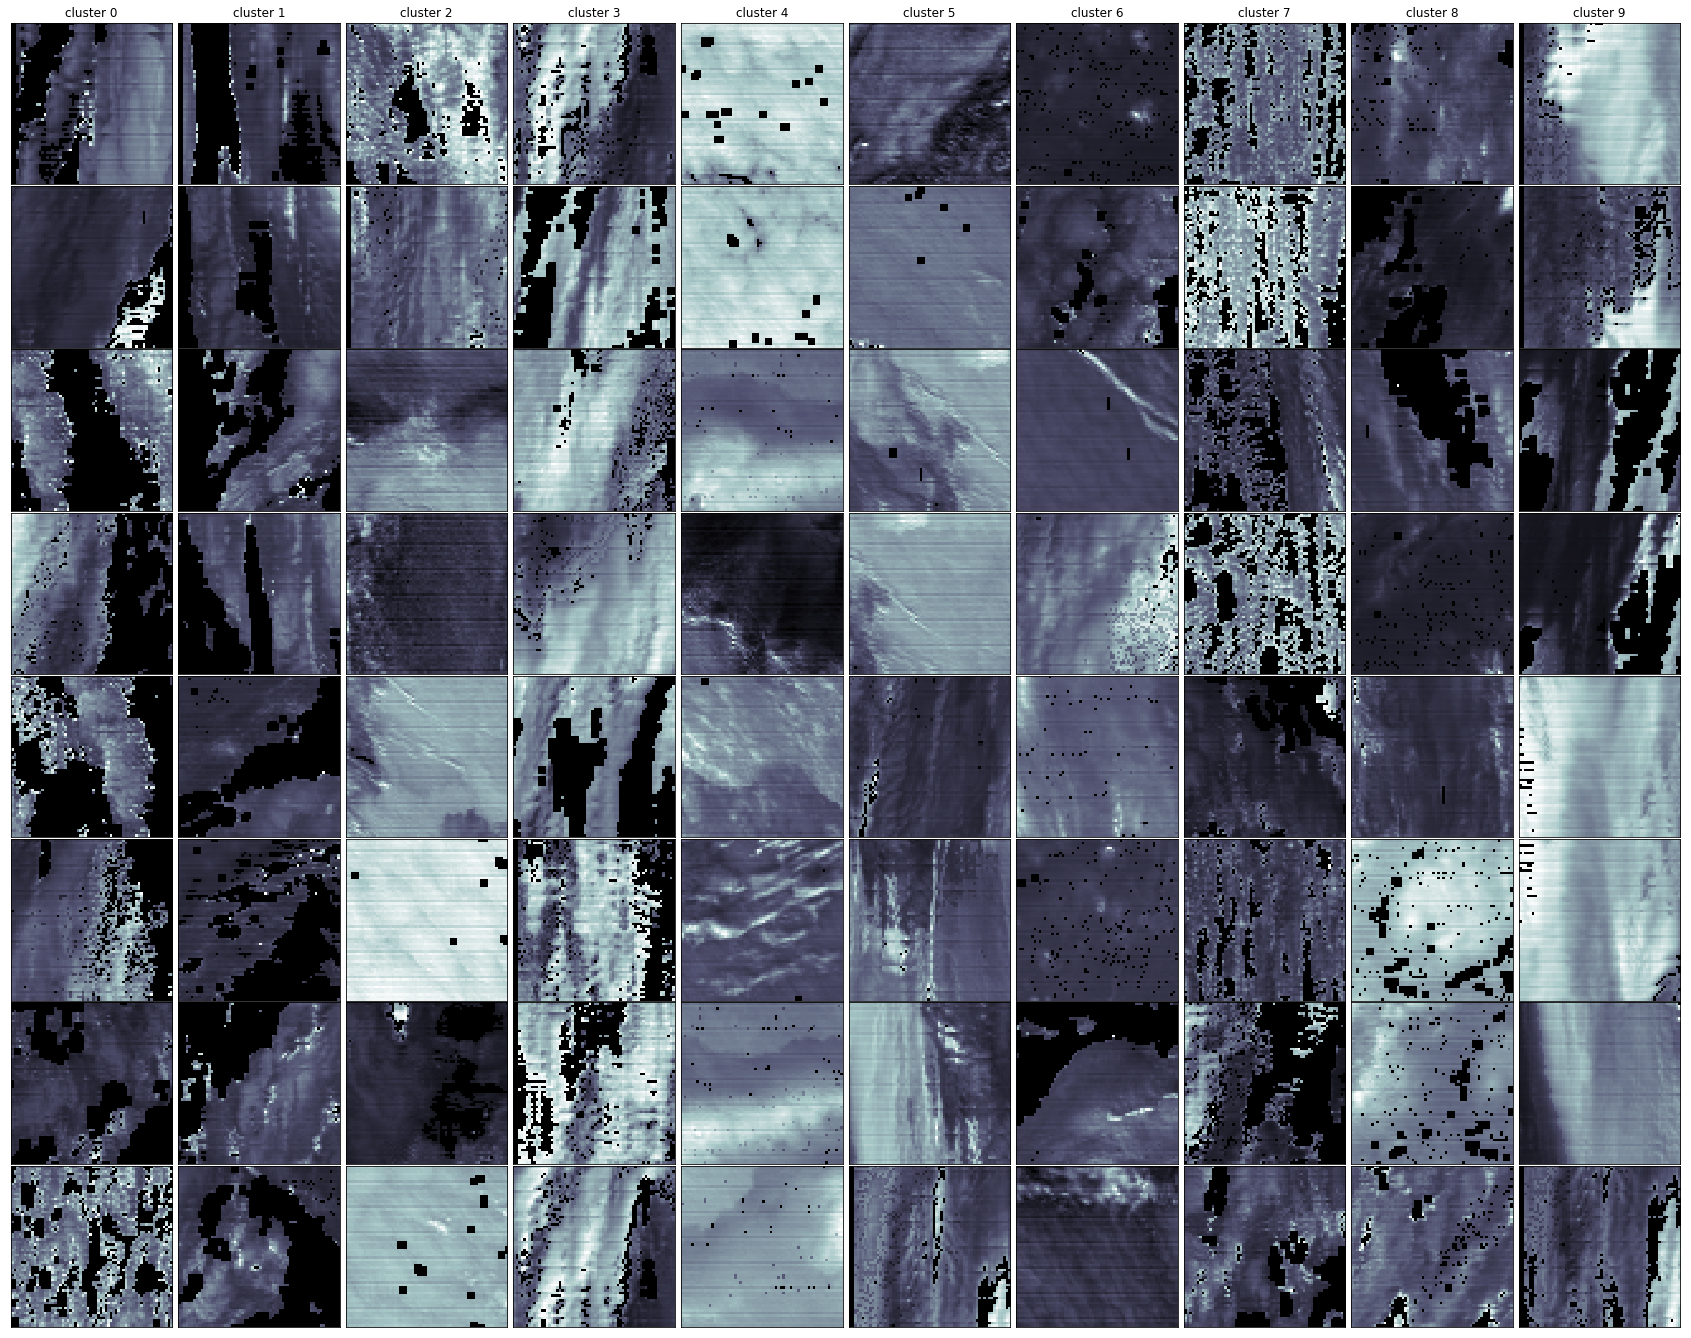

In [214]:
%matplotlib inline
fig, ax = plot_cluster_samples(imgs, km.labels_)


Text(0.5,0,'PC 3')

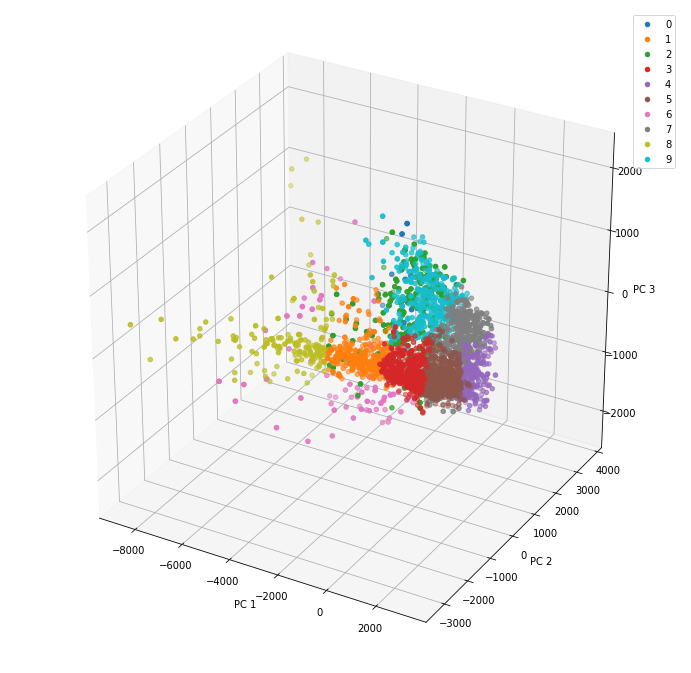

In [220]:
%matplotlib inline
dim = (0,1,2)
labels = sc.labels_

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(1, 1, 1, projection='3d')

xs_, ys_, zs_ = centered.dot(evecs[:,dim]).transpose()

for l in np.unique(labels):
    i = np.where(labels == l)
    ax.scatter(xs_[i], ys_[i], zs_[i], label=l)
ax.legend()

ax.set_xlabel("PC %d"%(dim[0] + 1))
ax.set_ylabel("PC %d"%(dim[1] + 1))
ax.set_zlabel("PC %d"%(dim[2] + 1))

Looking at the PCA projection, it seems the AE does not seperate different cloud types but rather embeds most kinds of clouds into a single manifold, this perhaps rules out density based clustering techniques

### Cluster similarity Analysis

### Interpolation

In [216]:
decoder = tf.keras.models.Sequential()
for l in ae.layers[7:]:
    decoder.add(l)

In [217]:
cluster1 = imgs[sc.labels_ == 6]
hid1, enc1 = ae.predict(cluster1[[0]])
hid2, enc2 = ae.predict(cluster1[[14]])

In [218]:
np.unique(sc.labels_, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32),
 array([ 24, 299, 483, 397, 246, 512, 145, 541, 166, 387]))

<IPython.core.display.Javascript object>


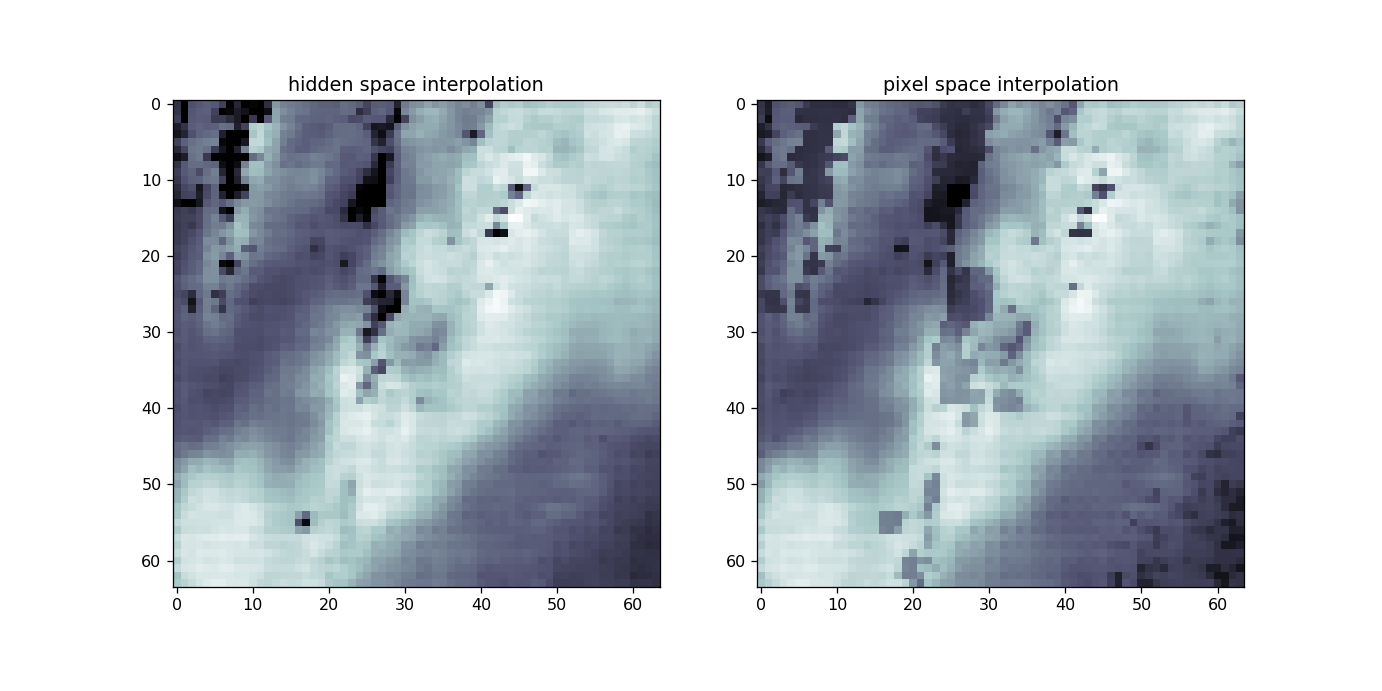

In [223]:
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
# No joke repeating those ^^ prevents some matplotlib / jupyter error

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
chan = 0

ims = []
for z in np.linspace(0, 1, 100):
    img1 = decoder.predict((1 - z) * hid1 + z * hid2)
    img2 = enc1  * (1 - z) + z * enc2
    im1 = ax1.imshow(img1[0,:,:,chan], cmap="bone")
    im2 = ax2.imshow(img2[0,:,:,chan], cmap="bone")
    ax1.set_title("hidden space interpolation")
    ax2.set_title("pixel space interpolation")
    ims.append([im1, im2])

ani = animation.ArtistAnimation(fig, ims, interval=100, blit=True,
                                repeat_delay=100)

if False: #save
    Writer = animation.writers['ffmpeg']
    writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
    ani.save('interpolation2.mp4', writer=writer)


Observe the transformation from one cloud to another (post autoencoding). On the left, the images are decoded from an interpolation in the hidden space. On the right, the images are interpolated pixels. The hidden space interpolation respects edges and offers a more "natural" interpolation between clouds.

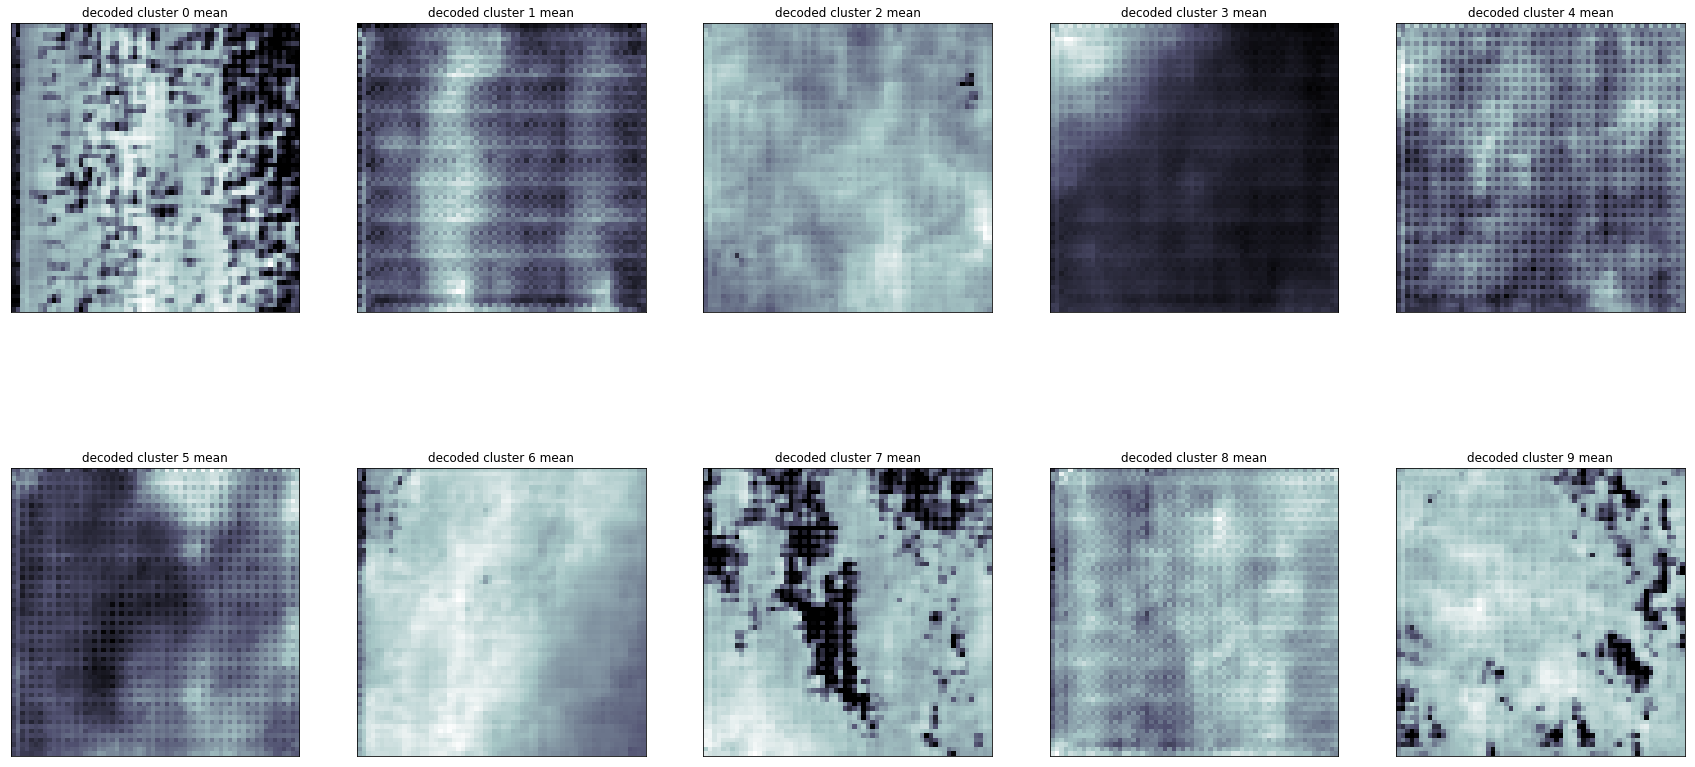

In [266]:
%matplotlib inline

fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(30, 15))

for i in range(10):
    m = ae.predict(imgs[sc.labels_ == i][:15])[0]
    m = m.mean(axis=0)
    m = np.expand_dims(m, axis=0)
    m = decoder.predict(m)
    
    a = ax[i // 5, i % 5]
    a.set_title("decoded cluster %d mean"%i)
    a.imshow(m[0,:,:,0], cmap="bone")
    a.set_xticks([]); a.set_yticks([])

It seems taking the mean of the cluster and decoding does not produce meaningful results. This suggests that the AE latent manifold is not convex

In [237]:
m.shape

(1, 64, 64, 3)

### TODO Similarity metrics for unlabeled data
* Silhouette Coefficient
* Calinski-Harabaz Index